# Short beam

In [1]:
# import API
import pwpp
from pwpp import *
import pickle
filename='Short'

In [2]:
# load
infile = open(filename,'rb')
ath_y,ath_x,adist_y,adist_x,da,a0,Deltalst,Np_th,Np_smpl,Np_eq29 = pickle.load(infile)
infile.close()

In [3]:
# parameters
# laser
I21 = 5; #[]
lbd = 0.8; #[\mu m]
a0 = 0.855*sqrt(1e3*I21)*lbd; #[]
W0 = 2; #[\mu m]
tau = 30; #[fs]
w0 = 2*pi*c/(lbd*1e-6)*hbar/e*1e-9; #[GeV]
zR = pi*W0**2/lbd; #[\mu m]
# beam
E0 = 2; #[GeV]
g0 = E0/m; #[]
R = 6; #[\mu m]
sigmaR = R/sqrt(2); #[\mu m]
Qb = 100 * 1e-12; #[C]
Nb = Qb/e; #[]
#
n = tau*c/(lbd*1e-6)*1e-15; #[]
wcc = wc(g0, a0, w0, n); #[GeV]

# Interpolate N+
amin = 2
a0int = np.linspace(amin,a0,200);
Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int])
Npinterp1d = interpolate.interp1d(a0int, Npint)

# analytical distribution
def dNda(a,Delta):
    """short beam"""
    return Nb * (W0/R)**2 / a * ( (a/a0)**((W0/R)**2) ) * iv(0,2*Delta*W0/R**2 * sqrt(log(a0/a))) * exp(-(Delta/R)**2);

# Data from ref. 1
Deltalst_epoch = [0, 5];
Np_epoch = [1e4, 4700];

# Distribution

In [7]:
# coordinate data
Nsmpl = int(1e8); #[]
Delta = 0; #[\mu m]
xdist = sigmaR*rng.standard_normal(Nsmpl) + Delta #[\mu m]
ydist = sigmaR*rng.standard_normal(Nsmpl) #[\mu m]
zdist = sigmaR*rng.standard_normal(Nsmpl) #[\mu m]

# calculate a
adim = 50; #[]
nbins = 20; #[]
alst = np.linspace(0.01*a0,0.999*a0,adim); #[]
abins = np.linspace(0.01*a0,0.999*a0,nbins); #[]
da = abins[1]-abins[0]; #[]
adist = gauss3D(0, xdist, ydist, a0, W0, lbd) #[]

# get histograms
adist_y,adist_x = np.histogram(adist,abins)
# normalize to Nb
adist_y, adist_x = adist_y*Nb/Nsmpl, arraycenter(adist_x)
# analytical distribution
ath_y,ath_x = dNda(alst,Delta), alst

# Displacement

In [10]:
# coordinate data
Nsmpl = int(5e6); #[]
Delta = 0; #[\mu m]
xdist = sigmaR*rng.standard_normal(Nsmpl) + Delta
ydist = sigmaR*rng.standard_normal(Nsmpl)
zdist = sigmaR*rng.standard_normal(Nsmpl)

# simulation parameters
Deltalst = np.linspace(0,10,13); #[\mu m]
dx = (Deltalst[1]-Deltalst[0]); #[\mu m]
Np_th = np.zeros(len(Deltalst));
Np_laplace = np.zeros(len(Deltalst));
Np_smpl = np.zeros(len(Deltalst));

# blackburn eq(29)
Np_eq29 = 0.727*a0*w0*wcc/m**2 *(W0/R)**2 * exp(-(Deltalst/R)**2) * Np(g0, a0, w0, n) * Nb;

for i in trange(len(Deltalst)):
    Delta = Deltalst[i];
    
    # sampling from disk
    adist = gauss3D(0, xdist, ydist, a0, W0, lbd)
    adist2 = adist[adist > amin]
    dNp = np.array([Npinterp1d(a) for a in adist2 ])
    Np_smpl[i] = np.sum( dNp ) * Nb/Nsmpl

    # normalize distribution numerically
    Np_th[i] = quad(lambda a: dNda(a,Delta) * Np(g0,a,w0,n) ,amin,0.999*a0)[0] ;
    
    # update x
    xdist = xdist + dx

In [14]:
# save
outfile = open(filename,'wb')
pickle.dump([ath_y,ath_x,adist_y,adist_x,da,a0,Deltalst,Np_th,Np_smpl,Np_eq29],outfile)
outfile.close()

In [ ]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3.5))

plt.subplot(121)
plt.plot(ath_x, ath_y*da,'k--',label=r'Theory')
plt.plot(adist_x, adist_y,'.',label=r'Sampling')
plt.yscale('log')
plt.xlabel(r'$a_{0,\mathrm{eff}}$')
plt.ylabel(r'$\frac{dN_b}{da_{0,\mathrm{eff}}} \left[ \frac{Q_b}{100\mathrm{pC}} \right]$',labelpad=15)
#plt.ylim(0,1e4)
plt.xlim([0,50])
plt.xticks([0,10,20,30,40,50])
plt.yticks([1e6,1e7,1e8,1e9])
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)

plt.subplot(122)
plt.plot(Deltalst, Np_th,'k--',label="Theory")
plt.plot(Deltalst, Np_smpl,'.',label="Sampling")
plt.plot(Deltalst, Np_eq29,label="[48] eq.(29)")
plt.plot(Deltalst_epoch, Np_epoch,'o',label="[48] Simulation",fillstyle='none',color='crimson')
plt.xlabel(r'$\Delta_\bot [\mu \textrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{Q_b}{100\mathrm{pC}} \right]$',labelpad=15)
plt.xlim([-0.2,max(Deltalst)+0.2])
#plt.ylim(0,1e4)
plt.legend(frameon=False,loc='upper right')
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.yticks([0,5e3,1e4,1.5e4,2e4])
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.tight_layout()
#plt.savefig('3DT.pdf')
plt.show()

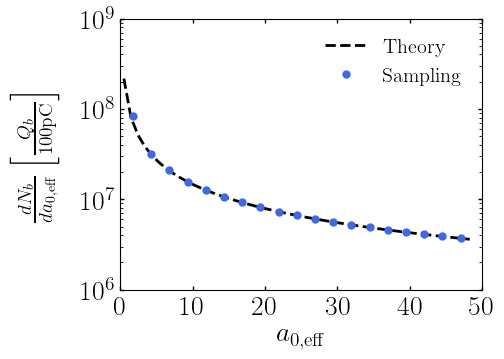

In [23]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(ath_x, ath_y*da,'k--',label=r'Theory')
plt.plot(adist_x, adist_y,'.',label=r'Sampling')
plt.yscale('log')
plt.xlabel(r'$a_{0,\mathrm{eff}}$')
plt.ylabel(r'$\frac{dN_b}{da_{0,\mathrm{eff}}} \left[ \frac{Q_b}{100\mathrm{pC}} \right]$',labelpad=15)
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
#plt.ylim(0,1e4)
plt.xlim([0,50])
plt.xticks([0,10,20,30,40,50])
plt.yticks([1e6,1e7,1e8,1e9])
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (np.log10(ymax)-np.log10(ymin))/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('3DT_a.pdf')
plt.show()

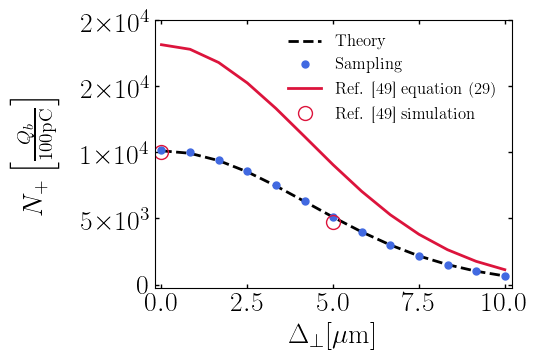

In [4]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(Deltalst, Np_th,'k--',label="Theory")
plt.plot(Deltalst, Np_smpl,'.',label="Sampling")
plt.plot(Deltalst, Np_eq29,label="Ref. [49] equation (29)")
plt.plot(Deltalst_epoch, Np_epoch,'o',label="Ref. [49] simulation",fillstyle='none',color='crimson')
plt.xlabel(r'$\Delta_\bot [\mu \textrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{Q_b}{100\mathrm{pC}} \right]$',labelpad=15)
plt.legend(frameon=False,loc='upper right',fontsize=12)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.xlim([-0.2,max(Deltalst)+0.2])
plt.xticks([0,2.5,5,7.5,10])
plt.yticks([0,5e3,1e4,1.5e4,2e4])
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('3DT_b.pdf')
plt.show()